<a href="https://colab.research.google.com/github/kridtapon/Oscillator-Volatility-Reversal-OVR-/blob/main/Oscillator_%26_Volatility_Reversal_(OVR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Chande Momentum Oscillator (CMO)
def calculate_cmo(df, period=14):
    """
    Calculate Chande Momentum Oscillator (CMO).
    """
    diff = df['Close'].diff()
    gains = diff.where(diff > 0, 0).rolling(window=period).sum()
    losses = -diff.where(diff < 0, 0).rolling(window=period).sum()
    cmo = (gains - losses) / (gains + losses) * 100
    return cmo

# Function to calculate Mass Index (MI)
def calculate_mass_index(df, period=25):
    """
    Calculate Mass Index (MI).
    """
    high_low_range = df['High'] - df['Low']
    ema_high_low = high_low_range.ewm(span=period).mean()
    mass_index = (high_low_range / ema_high_low).rolling(window=period).sum()
    return mass_index

# Define the stock symbol and time period
symbol = 'META'  # Example symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate Chande Momentum Oscillator (CMO)
df['CMO'] = calculate_cmo(df)

# Calculate Mass Index (MI)
df['MI'] = calculate_mass_index(df)

# Define Entry and Exit signals based on CMO and Mass Index Strategy
# Buy Signal: CMO crosses above zero, and MI is decreasing from a high value
df['Buy_Signal'] = (df['CMO'] > 0) & (df['MI'] < df['MI'].shift(30))

# Sell Signal: CMO crosses below zero, and MI is increasing from a low value
df['Sell_Signal'] = (df['CMO'] < 0) & (df['MI'] > df['MI'].shift(30))

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Buy_Signal'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Sell_Signal'].shift(1).fillna(False).astype(bool).to_numpy()

# Create portfolio using 'Open' prices
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-1f9c0d5fb1cf>:52: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-5-1f9c0d5fb1cf>:53: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                            241120.23037
Total Return [%]                        141.12023
Benchmark Return [%]                    187.56104
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4973.791228
Max Drawdown [%]                        59.342952
Max Drawdown Duration           670 days 00:00:00
Total Trades                                   19
Total Closed Trades                            19
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            52.631579
Best Trade [%]                          56.381793
Worst Trade [%]                        -31.345839
Avg Winning Trade [%]                   21.659404
Avg Losing Trade [%]                    -9.579958


Streaming output truncated to the last 5000 lines.

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-34-ca12129a01fd>:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-34-ca12129a01fd>:49: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-34-ca12129a01fd>:50: FutureWarning:

Downcasting object dtype arrays on .fillna

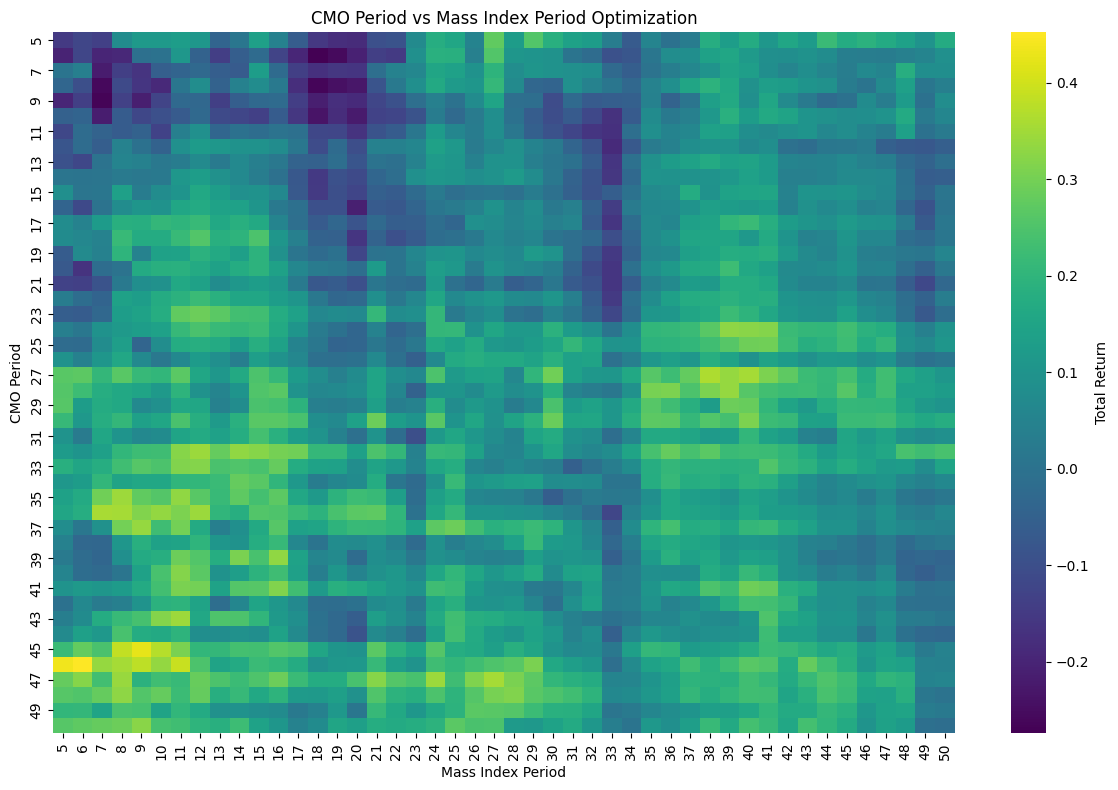

Best CMO Period: 46, Best MI Period: 6, Total Return: 45.23%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Chande Momentum Oscillator (CMO)
def calculate_cmo(df, period):
    diff = df['Close'].diff()
    gains = diff.where(diff > 0, 0).rolling(window=period).sum()
    losses = -diff.where(diff < 0, 0).rolling(window=period).sum()
    cmo = (gains - losses) / (gains + losses) * 100
    return cmo

# Mass Index (MI)
def calculate_mass_index(df, period):
    high_low_range = df['High'] - df['Low']
    ema_high_low = high_low_range.ewm(span=period).mean()
    mass_index = (high_low_range / ema_high_low).rolling(window=period).sum()
    return mass_index

# Download historical data
symbol = 'GLD'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Parameter ranges
cmo_range = range(5, 51)
mi_range = range(5, 51)

# Store results
results = pd.DataFrame(index=cmo_range, columns=mi_range)

# Grid search
for cmo_p in tqdm(cmo_range, desc="Optimizing CMO"):
    for mi_p in mi_range:
        data = df.copy()
        data['CMO'] = calculate_cmo(data, cmo_p)
        data['MI'] = calculate_mass_index(data, mi_p)

        data['Buy_Signal'] = (data['CMO'] > 0) & (data['MI'] < data['MI'].shift(30))
        data['Sell_Signal'] = (data['CMO'] < 0) & (data['MI'] > data['MI'].shift(30))

        data_test = data[(data.index.year >= 2020) & (data.index.year <= 2025)]

        entries = data_test['Buy_Signal'].shift(1).fillna(False).astype(bool).to_numpy()
        exits = data_test['Sell_Signal'].shift(1).fillna(False).astype(bool).to_numpy()

        try:
            pf = vbt.Portfolio.from_signals(
                close=data_test['Open'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001,
                slippage=0.002,
                freq='D'
            )
            results.loc[cmo_p, mi_p] = pf.total_return()
        except Exception:
            results.loc[cmo_p, mi_p] = np.nan

# Convert to float
results = results.astype(float)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(results, annot=False, fmt=".2%", cmap="viridis", cbar_kws={'label': 'Total Return'})
plt.title("CMO Period vs Mass Index Period Optimization")
plt.xlabel("Mass Index Period")
plt.ylabel("CMO Period")
plt.tight_layout()
plt.show()

# Best parameters
best_cmo = results.stack().idxmax()[0]
best_mi = results.stack().idxmax()[1]
best_return = results.loc[best_cmo, best_mi]
print(f"Best CMO Period: {best_cmo}, Best MI Period: {best_mi}, Total Return: {best_return:.2%}")


In [ ]:
# Calculate Chande Momentum Oscillator (CMO)
df['CMO'] = calculate_cmo(df, 25)

# Calculate Mass Index (MI)
df['MI'] = calculate_mass_index(df, 39)

# Define Entry and Exit signals based on CMO and Mass Index Strategy
# Buy Signal: CMO crosses above zero, and MI is decreasing from a high value
df['Buy_Signal'] = (df['CMO'] > 0) & (df['MI'] < df['MI'].shift(30))

# Sell Signal: CMO crosses below zero, and MI is increasing from a low value
df['Sell_Signal'] = (df['CMO'] < 0) & (df['MI'] > df['MI'].shift(30))

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Buy_Signal'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Sell_Signal'].shift(1).fillna(False).astype(bool).to_numpy()

# Create portfolio using 'Open' prices
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

<ipython-input-29-e3c4716c5606>:18: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-29-e3c4716c5606>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           316091.226988
Total Return [%]                       216.091227
Benchmark Return [%]                   173.632821
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3423.787919
Max Drawdown [%]                        22.794465
Max Drawdown Duration           177 days 00:00:00
Total Trades                                   12
Total Closed Trades                            12
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                         126.147951
Worst Trade [%]                         -7.054811
Avg Winning Trade [%]                   29.951199
Avg Losing Trade [%]                    -2.710053


[*********************100%***********************]  1 of 1 completed


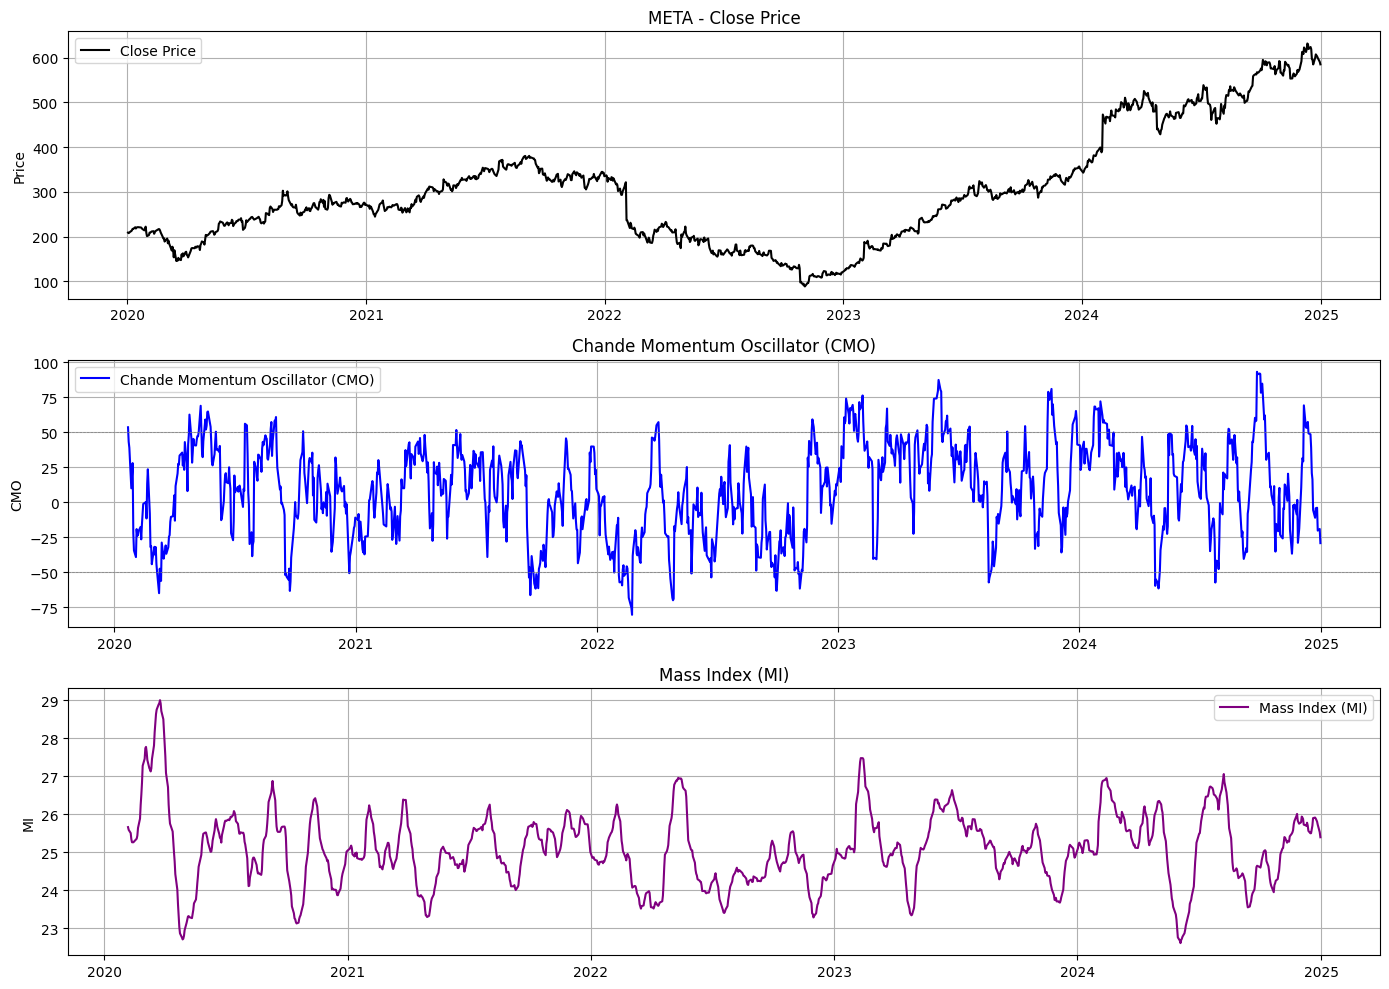

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate Chande Momentum Oscillator (CMO)
def calculate_cmo(df, period=14):
    diff = df['Close'].diff()
    gains = diff.where(diff > 0, 0).rolling(window=period).sum()
    losses = -diff.where(diff < 0, 0).rolling(window=period).sum()
    cmo = (gains - losses) / (gains + losses) * 100
    return cmo

# Function to calculate Mass Index (MI)
def calculate_mass_index(df, period=25):
    high_low_range = df['High'] - df['Low']
    ema_high_low = high_low_range.ewm(span=9, adjust=False).mean()
    ema_ema = ema_high_low.ewm(span=9, adjust=False).mean()
    ratio = ema_high_low / ema_ema
    mass_index = ratio.rolling(window=period).sum()
    return mass_index

# Parameters
symbol = 'META'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Fetch data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Compute indicators
df['CMO'] = calculate_cmo(df)
df['MI'] = calculate_mass_index(df)

# Plotting
plt.figure(figsize=(14, 10))

# Plot Close Price
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='black')
plt.title(f'{symbol} - Close Price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Plot CMO
plt.subplot(3, 1, 2)
plt.plot(df['CMO'], label='Chande Momentum Oscillator (CMO)', color='blue')
plt.axhline(50, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(-50, color='gray', linestyle='--', linewidth=0.5)
plt.title('Chande Momentum Oscillator (CMO)')
plt.ylabel('CMO')
plt.grid(True)
plt.legend()

# Plot Mass Index
plt.subplot(3, 1, 3)
plt.plot(df['MI'], label='Mass Index (MI)', color='purple')
plt.title('Mass Index (MI)')
plt.ylabel('MI')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
